# Pricing equity options denominated in Euro
In this notebook I price American equity options denominated in Euro using volatility tracking, riskless yield curve construction, and options pricing code from this package. I ensure that all market and economic data required for pricing is obtained from [FRED](https://fred.stlouisfed.org), [Eurostat](https://ec.europa.eu/eurostat/data/database), and [Yahoo-finance](https://finance.yahoo.com) using [pandas-datareader](https://pydata.github.io/pandas-datareader/).

This notebook can also be used as a tutorial to using the `pricing.curves`, `pricing.options`, `volatility.parameter_estimators`, and `volatility.volatility_trackers` packages in this repository.

## Constructing a riskless yield curve for Euro
Since I already covered it in a separate notebook, I will simply import it. The resultant YieldCurve object is
assigned to the `curve` variable

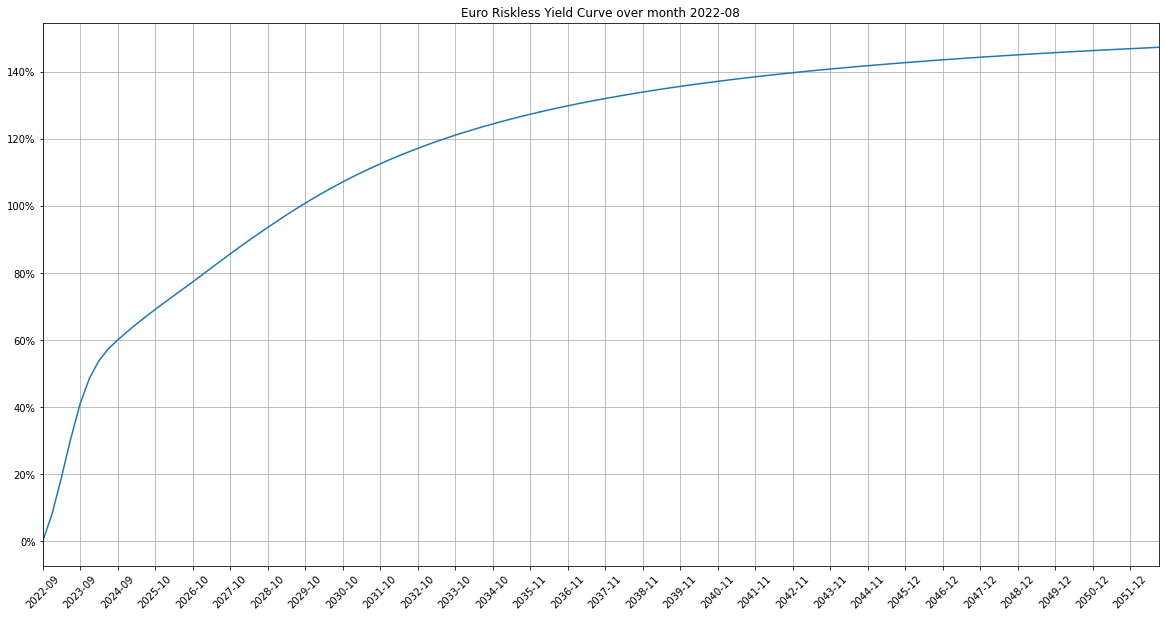

In [1]:
%run euro-riskless-yield-construction-example.ipynb

## Estimating and forecasting volatility of the stock, options on which we want to price
Now that the riskless curve has been constructed, the next thing to do is obtain an accurate volatility estimate for the stock whose options we want to price. There are various methods for doing it. The most common are the Exponentially Weighted Moving Average (EWMA) and GARCH(1, 1) methods. You can read about them on the Internet or delve into John C. Hull's [Risk Management and Financial Institutions](http://www-2.rotman.utoronto.ca/~hull/riskman/index.html) or [Options, Futures, and Other Derivatives](http://www-2.rotman.utoronto.ca/~hull/ofod/index.html). For the purposes of pricing options GARCH(1, 1) is preferred because it supports volatility forecasting for future maturities by incorporating mean reversion (and volatility of equities lends itself to mean reversion). In this notebook I therefore use GARCH(1, 1).

### GARCH(1, 1)
In order to use GARCH(1, 1) one first needs to estimate it's parameters based on the historical data for the equity whose options you want to price. GARCH(1, 1) has three parameters &mdash; ω, α, and β. I use the maximum likelihood method to estimate them, which is an optimization task. The `volatility.parameter_estimators.GARCHParameterEstimator` class comes to rescure. _Implementation detail_: In that class I use Google's TensorFlow 2.x to optimize for maximum likelihood. Alternatively I could've used [SciPy](https://docs.scipy.org/doc/scipy/tutorial/optimize.html). *NB* When estimating ω, α, and β it's vital to use _adjusted closing_ prices, i.e. prices that have been adjusted for dividends and stock splits. Failing to do that will result in too high an estimate. Yahoo Finance provides such prices in the `Adj Close` column.

#### Estimating GARCH(1, 1) parameters for Shell plc

In [2]:
# Shell plc as traded on Euronext Amsterdam
TICKER = 'SHELL.AS'

# I'll use price changes since 1st Jan 2018 to estimate GARCH(1, 1) ω, α, and β parameters
start = date(2018, 1, 1)
data = web.get_data_yahoo(TICKER, start, today)
asset_prices = data['Adj Close']

vol_estimator = parameter_estimators.GARCHParameterEstimator(asset_prices)
print('Optimal values for GARCH(1, 1) parameters:\n\tω=%.12f, α=%.5f, β=%.5f'
      % (vol_estimator.omega, vol_estimator.alpha, vol_estimator.beta))

/usr/local/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


Objective function: 8576.55281 after 114 iterations
Optimal values for GARCH(1, 1) parameters:
	ω=0.000006838341, α=0.10759, β=0.88250


#### Forecasting volatility for Shell plc
Now that we have the obtined optimal values for GARCH(1, 1) parameters ω, α, and β, we can proceed to forecast the volatility of Shell stock. I crated class `volatility.parameter_estimators.GARCHVolatilityTracker` to assist in it.

In [3]:
vol_tracker = volatility_trackers.GARCHVolatilityTracker(vol_estimator.omega, vol_estimator.alpha,
                                                         vol_estimator.beta, asset_prices)

# Let's get volatility forecast for December 16th options
maturity_date = date(2022, month=12, day=16)
vol = vol_tracker.get_annual_term_volatility_forecast(curve.to_years(maturity_date))
print('Volatility of %s for term %.4f years: %.5f' % (TICKER, curve.to_years(maturity_date), vol))

Volatility of SHELL.AS for term 0.2301 years: 0.43196


#### Optional: Visualizing historical and future volatility of Shell stock for 200 business days into the future

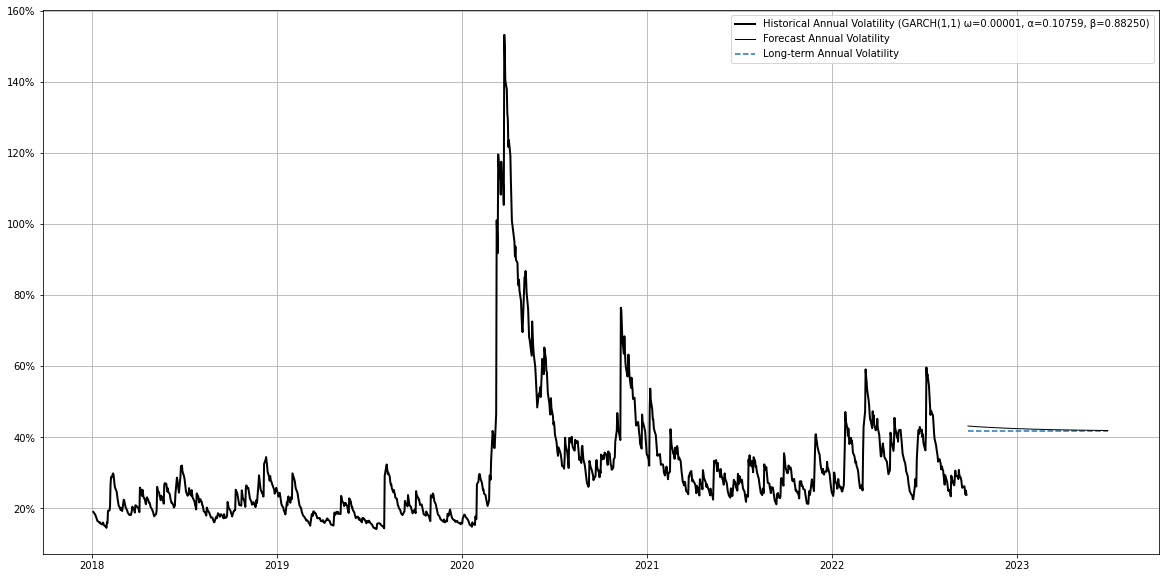

In [4]:
import matplotlib.pyplot as plt
x = vol_tracker.get_dates()
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 1, 1)
ax.plot(x, vol_tracker.get_annual_volatilities() * 100,
        label='Historical Annual Volatility (GARCH(1,1) ω=%.5f, α=%.5f, β=%.5f)' 
            % (vol_estimator.omega, vol_estimator.alpha, vol_estimator.beta),
        linewidth=2, color='k')

# Forecasting volatility of Shell stock 200 days into the future
future_volatilities = vol_tracker.get_annual_volatility_forecast_for_next_n_days(200)
ax.plot(future_volatilities.index, future_volatilities * 100, label='Forecast Annual Volatility', linewidth=1, color='k')
ax.hlines(vol_tracker.get_annual_long_term_volatility() * 100, xmin=future_volatilities.index[0], xmax=future_volatilities.index[-1],
         label="Long-term Annual Volatility", linestyle='--')
ax.legend()
ax.grid(True)
ax.yaxis.set_major_formatter(mtick.PercentFormatter())

## Pricing using Black-Scholes-Merton Pricer
The Black-Scholes-Merton model can be used to price European options, including on stock that pays dividends. With enough customizations it can also be used to price American call options (even those paying dividends). This is based on the fact that it is never optimal to exercise an American call option prematurely except on days immediately preceeding ex-dividend days for the stock. The `pricing.options.BlackScholesMertonPricer` class from this repository implements this customization to price American call options.

Let's put it to use to price an Shell call option with a strike of €28. Shell pays dividends. It's essential to take into account dividends that get payed during the lifetime of an option to get an accurate price.

In [5]:
strike = 28.

# An approximate rule for Shell's ex-dividend dates
idx = (pd.date_range(date(2022, 8, 12), freq='WOM-2FRI', periods=20)[::3] - BDay(1))
divs = pd.Series([.24] * len(idx), index=idx, name=TICKER + ' Dividends')

# Shell aims to grow the dividend per share by around 4 percent every year
divs.loc['2023':] *= 1.04
divs.loc['2024':] *= 1.04

cur_price = asset_prices[-1]
pricer = options.BlackScholesMertonPricer(maturity_date, vol_tracker, strike, curve, cur_price,
                                          ticker=TICKER, dividends=divs, opt_type=options.OptionType.AMERICAN)
print(pricer)

SHELL.AS AMERICAN call option with strike 28.0 and maturity 2022-12-16, price: 1.01, σ: 0.4320, Δ: 0.334, Γ: 0.071, ν: 4.307


Sometimes you might want to price using _an implied volatility_ for a given expiry date. You get the implied volatilty from the option prices of market makers. The `pricing.options.BlackScholesMertonPricer` class supports this. Just enter the implied volatility value instead of passing it a volatility_tracker object:

In [6]:
# Pricing with an implied volatility of 35%
pricer = options.BlackScholesMertonPricer(maturity_date, .35, strike, curve, cur_price,
                                          ticker=TICKER, dividends=divs, opt_type=options.OptionType.AMERICAN)
print(pricer)

SHELL.AS AMERICAN call option with strike 28.0 and maturity 2022-12-16, price: 0.67, σ: 0.3500, Δ: 0.283, Γ: 0.082, ν: 4.007


As you can see, a lower volatility resulted in a decrease of €34 in the price.

Let's now price an Shell call option with a longer maturity. This is a little more complex as there are ex-dividend dates during the option's lifetime.

In [7]:
maturity_date = date(2023, month=9, day=15)
pricer = options.BlackScholesMertonPricer(maturity_date, vol_tracker, strike, curve, cur_price,
                                          ticker=TICKER, dividends=divs, opt_type=options.OptionType.AMERICAN)
print(pricer)

SHELL.AS AMERICAN call option with strike 28.0 and maturity 2023-09-15, price: 5.97, σ: 0.4319, Δ: 0.733, Γ: 0.032, ν: 7.807


If you wonder where the volatility forecast of 43.19% came from, it came from the GARCH(1, 1) `vol_tracker` object I passed to the BlackScholesMertonPricer. You can easily see this:

In [8]:
vol_tracker.get_annual_term_volatility_forecast(curve.to_years(maturity_date))

0.4319105003674205

## Pricing using Binomial Tree Pricer
The Binomial Tree model can be used to price any European or American option, including on stock that pays dividends.

Let's put it to use to price a Shell call and put option with a strike of €28 and compare resulting prices for call options.

In [9]:
bin_tree_pricer = options.BinomialTreePricer(maturity_date, vol_tracker, strike, curve, cur_price,
                                             ticker=TICKER, dividends=divs, opt_type=options.OptionType.AMERICAN)
print(bin_tree_pricer)

print('Price difference between Black-Scholes-Merton and Binomial Treee pricers: %.6f'
      % abs(pricer.get_price() - bin_tree_pricer.get_price()))

SHELL.AS AMERICAN call option with strike 28.0 and maturity 2023-09-15, price: 6.06, σ: 0.4319, Δ: 0.736, Γ: 0.034, ν: 8.569
Price difference between Black-Scholes-Merton and Binomial Treee pricers: 0.089838


Let's now price an Shell put options with the same maturity. You cannot price put options with a BlackScholesMerton pricer, with a BinomialTreePricer you can.

In [10]:
bin_tree_pricer_put = options.BinomialTreePricer(maturity_date, vol_tracker, strike, curve, cur_price, is_call=False,
                                                 ticker=TICKER, dividends=divs, opt_type=options.OptionType.AMERICAN)
print(bin_tree_pricer_put)

SHELL.AS AMERICAN put option with strike 28.0 and maturity 2023-09-15, price: 3.83, σ: 0.4319, Δ: -0.587, Γ: 0.090, ν: 7.278


If you wish to price with a given implied volatility, just pass it to the pricer as the second parameter:

In [11]:
impl_vol = .35
bin_tree_pricer = options.BinomialTreePricer(maturity_date, impl_vol, strike, curve, cur_price,
                                             ticker=TICKER, dividends=divs, opt_type=options.OptionType.AMERICAN)
print(bin_tree_pricer)
bin_tree_pricer_put = options.BinomialTreePricer(maturity_date, impl_vol, strike, curve, cur_price, is_call=False,
                                                 ticker=TICKER, dividends=divs, opt_type=options.OptionType.AMERICAN)
print(bin_tree_pricer_put)

SHELL.AS AMERICAN call option with strike 28.0 and maturity 2023-09-15, price: 5.42, σ: 0.3500, Δ: 0.753, Γ: 0.040, ν: 7.259
SHELL.AS AMERICAN put option with strike 28.0 and maturity 2023-09-15, price: 3.30, σ: 0.3500, Δ: -0.725, Γ: 0.133, ν: 5.794
